In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import pandas as pd
from pathlib import Path
from read_roi import read_roi_zip
from collections import OrderedDict, Counter
import math
import PIL
from PIL import Image
from PIL.TiffTags import TAGS
import tkinter as tk
from tkinter import filedialog
import seaborn as sns

# Read, format and save raw data from ROIs #

In [26]:
kymoslopes = filedialog.askopenfilenames() # show an "Open" dialog box and return the path to the selected file
kymoslopes

('D:/Sofia/2020-11-17_R178L-Dyn/CH22_tub10uM_FEZ1-SCOC/tempIRM_tub10uM-results/kymoslopes_ctl.zip',
 'D:/Sofia/2020-11-17_R178L-Dyn/CH22_tub10uM_FEZ1-SCOC/tempIRM_tub10uM-results/kymoslopes_fez1-scoc.zip')

In [27]:
path = Path(kymoslopes[0]).parents[0]
path

WindowsPath('D:/Sofia/2020-11-17_R178L-Dyn/CH22_tub10uM_FEZ1-SCOC/tempIRM_tub10uM-results')

In [28]:
tubulin = '[Tubulin] ' r'$(\mu M)$'
tub = 'tub'

investigator = 'Sofia'

In [29]:
dateloc = str(path).find("2020")
date = str(path)[dateloc : dateloc+10]

name = []

for i in kymoslopes:
    nameloc = str(i).find("kymoslopes")
    name = name + [(str(i)[nameloc+11:-4])]

name,date

(['ctl', 'fez1-scoc'], '2020-11-17')

In [30]:
frame_analyzer = pd.read_csv(path.parents[0]/'frame_rates_avg.csv',sep=',')
pixel =  0.107 #0.107 #0.0633
frame_analyzer

,Directory,Mean,SD,Frames,Outliers,MeanWOutliers,SDWOutliers
0,D:\Sofia\2020-11-17_R178L-Dyn\CH22_tub10uM_FEZ...,5.04,0.02,500,2,13.83,196.28
1,D:\Sofia\2020-11-17_R178L-Dyn\CH22_tub10uM_FEZ...,5.04,0.03,499,1,5.04,0.08


In [31]:
def open_roi_poly(path):
    roi_data = read_roi_zip(path)
    roi_df = pd.DataFrame(columns=['Track ID','x1','x2','x3','y1','y2','y3'])
    for key in roi_data:
        roi_df = roi_df.append({'Track ID': roi_data[key]['name'],'x1': roi_data[key]['x'][0],'x2': roi_data[key]['x'][1],'x3': roi_data[key]['x'][2],'y1': roi_data[key]['y'][0],'y2': roi_data[key]['y'][1],'y3': roi_data[key]['y'][2]}, ignore_index=True)
    return roi_df

def open_roi_line(path):
    roi_data = read_roi_zip(path)
    roi_df = pd.DataFrame(columns=['Track ID','x1','x2','y1','y2'])
    for key in roi_data:
        roi_df = roi_df.append({'Track ID': roi_data[key]['name'],'x1': roi_data[key]['x1'],'x2': roi_data[key]['x2'],'y1': roi_data[key]['y1'],'y2': roi_data[key]['y2']}, ignore_index=True)
    return roi_df

In [32]:
Length = 'Length ' r'$(\mu m)$'
Lifetime = 'Lifetime ' r'$(min)$'
GrowthRate = 'Growth Rate ' r'$(\mu m / min)$'
TimeToNucleate = 'Time to Nucleate ' r'$(min)$'
ShrinkageLength = 'Shrink Length ' r'$(\mu m)$'
ShrinkageLifetime = 'Shrink Lifetime ' r'$(min)$'
ShrinkageRate = 'Shrink Rate ' r'$(\mu m / min)$'
poly_parameter_names = (Length,Lifetime,GrowthRate,TimeToNucleate)
line_parameter_names = (Length,Lifetime,GrowthRate,TimeToNucleate,ShrinkageLength,ShrinkageLifetime,ShrinkageRate)

In [33]:
def poly_dynamics(k):
        
    data = open_roi_poly(kymoslopes[k])
    #supp = open_roi_line(k,'start.zip')
    
    spf = frame_analyzer['Mean'][k];
    frames = frame_analyzer['Frames'][k]-2
    
    #suppn = len(supp)
    #start = sum(abs(supp['y2']-supp['y1']))/suppn;
    
    n = len(data)
    pre_df = {'Date': np.full((n), date),'Name': np.full((n), name[k]), 'Investigator': np.full((n), investigator)}
    df = pd.DataFrame(pre_df) 
    
    df[Length] = abs((data['x2']-data['x1'])*pixel)
    
    data[Lifetime] = abs((data['y2']-data['y1'])*spf/60)
    df[Lifetime] = data[[Lifetime,'y2']].apply(lambda x: x[Lifetime] if x['y2'] < frames-2 else np.NaN, axis=1)
    df[Lifetime] = data[[Lifetime,'y2']].apply(lambda x: x[Lifetime] if x[Lifetime] != 0 else np.NaN, axis=1)
    
    df[GrowthRate] = df[Length]/df[Lifetime]
    df[GrowthRate] = df[GrowthRate].apply(lambda x: x if x <= 5 else np.NAN )
    
    #df[TimeToNucleate] = (data['y1']-start)*spf/60
    
    df[ShrinkageLength] = abs((data['x3']-data['x2'])*pixel)
    df[ShrinkageLifetime] = abs((data['y3']-data['y2'])*spf/60)
    df[ShrinkageLifetime] = df[ShrinkageLifetime].apply(lambda x: np.NAN if x == 0 else x)
    df[ShrinkageRate] = df[ShrinkageLength]/df[ShrinkageLifetime]
    
    df.loc[pd.isnull(df[GrowthRate]), [Length,Lifetime,ShrinkageLength,ShrinkageLifetime,ShrinkageRate]] = np.NaN
    
    df['Rescues'] = df[[Length,ShrinkageLength]].apply(lambda x: True if abs(x[Length]-x[ShrinkageLength]) > pixel*5 else False, axis=1)
        
    return df

def line_dynamics(k):
        
    data = open_roi_line(kymoslopes[k])
    #data_even = data.iloc[::2].reset_index()
    #data_odd = data.iloc[1::2].reset_index()
    data_even = data
    data_odd = data
    
    #supp = open_roi_line(k,'start.zip')
    
    spf = frame_analyzer['Mean'][k];
    frames = frame_analyzer['Frames'][k]-2
    
    #suppn = len(supp)
    #start = sum(abs(supp['y2']-supp['y1']))/suppn;
    
    n = len(data_even)
    pre_df = {'Date': np.full((n), date)}
    df = pd.DataFrame(pre_df) 
    
    data_even[Length] = abs((data_even['x2']-data_even['x1'])*pixel)
    data_even[Lifetime] = abs((data_even['y2']-data_even['y1'])*spf/60)
    df[GrowthRate] = data_even[Length]/data_even[Lifetime]
    df[GrowthRate] = df[GrowthRate].apply(lambda x: x if x <= 5 else np.NaN )
    
    data[Lifetime] = abs((data_odd['y2']-data_odd['y1'])*spf/60)
    df[Lifetime] = data[[Lifetime,'y2']].apply(lambda x: x[Lifetime] if x['y2'] < frames else np.NaN, axis=1)
    
    df[Length] = df[GrowthRate]*df[Lifetime]
    
    #df[TimeToNucleate] = ((data_odd[['y1','y2']].min(axis=1))-start)*spf/60
    
    df.loc[pd.isnull(df[GrowthRate]), [Length,Lifetime]] = np.NaN
    
    df = df[['Date',Length,Lifetime,GrowthRate]]
        
    return df

In [34]:
path

WindowsPath('D:/Sofia/2020-11-17_R178L-Dyn/CH22_tub10uM_FEZ1-SCOC/tempIRM_tub10uM-results')

In [35]:
df = poly_dynamics(0)
for i in range(1,len(kymoslopes)):
    df0 = poly_dynamics(i)
    df = df.append(df0, ignore_index=True)

df.to_csv(path/(investigator+'_'+date +'.csv'), encoding='utf-8', index=False)
df

,Date,Name,Investigator,Length $(\mu m)$,Lifetime $(min)$,Growth Rate $(\mu m / min)$,Shrink Length $(\mu m)$,Shrink Lifetime $(min)$,Shrink Rate $(\mu m / min)$,Rescues
0,2020-11-17,ctl,Sofia,2.166750,4.095000,0.529121,2.407500,0.084000,28.660714,False
1,2020-11-17,ctl,Sofia,3.450750,3.927000,0.878724,3.531000,0.168000,21.017857,False
2,2020-11-17,ctl,Sofia,1.177000,1.155000,1.019048,1.284000,NaN,NaN,False
3,2020-11-17,ctl,Sofia,1.480167,2.114000,0.700173,1.747667,0.028000,62.416186,False
4,2020-11-17,ctl,Sofia,2.924667,5.250000,0.557079,2.799833,0.181999,15.383771,False
...,...,...,...,...,...,...,...,...,...,...
144,2020-11-17,fez1-scoc,Sofia,6.527793,6.626668,0.985079,6.584067,0.441777,14.903607,False
145,2020-11-17,fez1-scoc,Sofia,2.703807,2.918596,0.926407,2.872796,0.221105,12.992903,False
146,2020-11-17,fez1-scoc,Sofia,2.760137,3.228144,0.855023,3.098113,0.221105,14.011956,False
147,2020-11-17,fez1-scoc,Sofia,5.173489,6.048003,0.855405,6.185693,0.176583,35.030044,True


In [19]:
dfmean = df.groupby('CH').mean()
#dfmean.to_csv(path/(date+'_0_mean.csv'), encoding='utf-8', index=False)
dfmean

,[Tubulin] $(\mu M)$,[DCX] $(n M)$,Length $(\mu m)$,Lifetime $(min)$,Growth Rate $(\mu m / min)$,Time to Nucleate $(min)$,Shrink Length $(\mu m)$,Shrink Lifetime $(min)$,Shrink Rate $(\mu m / min)$,Rescues
CH,,,,,,,,,,
11,6.0,0.0,1.551084,3.915923,0.419526,8.500005,1.668373,0.124822,17.435893,0.000000
13,6.0,50.0,1.963200,5.173983,0.395073,4.672291,1.421312,0.876648,1.981930,0.404040
14,14.0,0.0,8.588767,8.034216,1.013685,2.245469,8.702698,0.392354,34073.354860,0.042105
21,6.0,25.0,1.030617,3.091548,0.412461,4.772109,1.022975,0.549640,2.533771,0.000000
22,6.0,35.0,1.627995,4.755885,0.361557,8.036618,1.552219,0.728448,2.683674,0.033898
23,6.0,14.0,2.296455,4.822238,0.495339,1.460301,2.223471,0.938478,2.747288,0.037736
24,14.0,0.0,6.276263,5.907106,1.030292,2.346442,6.284868,0.279778,31.892282,0.035294


In [56]:
dfstd = df.groupby('CH').std()
#dfstd.to_csv(path/(date+'_0_std.csv'), encoding='utf-8', index=False)
dfstd

,[Tubulin] $(\mu M)$,[DCX] $(n M)$,Length $(\mu m)$,Lifetime $(min)$,Growth Rate $(\mu m / min)$,Time to Nucleate $(min)$,Shrink Length $(\mu m)$,Shrink Lifetime $(min)$,Shrink Rate $(\mu m / min)$,Rescues
CH,,,,,,,,,,
11,0.0,0.0,1.060355,2.818422,0.090169,7.249800,1.063288,0.094311,12.365341,0.000000
13,0.0,0.0,1.090301,3.149188,0.058311,6.158173,0.775537,0.634460,0.955795,0.493203
14,0.0,0.0,6.701317,5.907656,0.173452,4.149546,6.674072,0.382873,328292.873802,0.201895
21,0.0,0.0,0.525048,2.308929,0.206109,5.499986,0.528457,0.474889,1.195934,0.000000
22,0.0,0.0,0.773276,2.503845,0.072705,6.347061,0.758083,0.439104,1.376468,0.182521
23,0.0,0.0,1.312658,3.096322,0.069902,2.139997,1.372377,0.558079,2.410612,0.191462


# Preliminary plot Histograms #

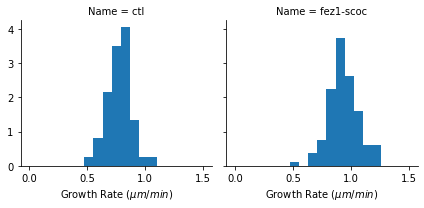

In [36]:
g = sns.FacetGrid(df, col='Name', margin_titles=True)
bins = np.linspace(0, 1.5, 20)
g.map(plt.hist, GrowthRate, bins=bins, density=True)

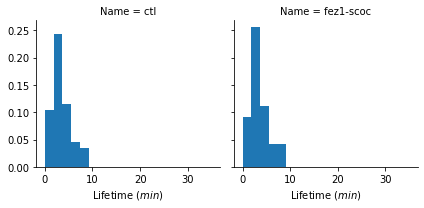

In [50]:
g = sns.FacetGrid(df, col='Name', margin_titles=True)
bins = np.linspace(0, 35, 20)
g.map(plt.hist, Lifetime, bins=bins, density=True)

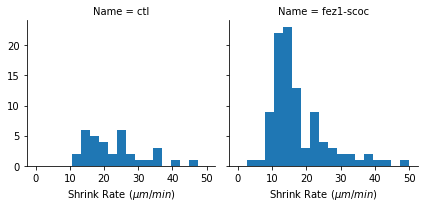

In [52]:
g = sns.FacetGrid(df, col='Name', margin_titles=True)
bins = np.linspace(0, 50, 20)
g.map(plt.hist, ShrinkageRate, bins=bins)